# HM04 - Applied ML

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
from sklearn.cluster import KMeans
import sklearn

from sklearn.preprocessing import StandardScaler

In [2]:
#Load the data
data = pd.read_csv("CrowdstormingDataJuly1st.csv")

In [3]:
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [4]:
list(data.columns.values)

['playerShort',
 'player',
 'club',
 'leagueCountry',
 'birthday',
 'height',
 'weight',
 'position',
 'games',
 'victories',
 'ties',
 'defeats',
 'goals',
 'yellowCards',
 'yellowReds',
 'redCards',
 'photoID',
 'rater1',
 'rater2',
 'refNum',
 'refCountry',
 'Alpha_3',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp']

## 0. Data Cleaning

### 0.1 NaN Values

In [5]:
def columns_nanValues(data):
    # print all columns with at least one NaN value
    l = list()
    for c in data:
        if data[c].hasnans:
            l.append(c)
    return l

columns_nanValues(data)

['height',
 'weight',
 'position',
 'photoID',
 'rater1',
 'rater2',
 'Alpha_3',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp']

Some columns contains NaN values. For this homework, we will not be able to work with data having no *skin color* feature. Therefore we only keep instances with this information.

In [6]:
# We remove all instance with no 'photoID' information, since the skin color needs this information
data_clean = data[~data.photoID.isnull()]
nan_col = columns_nanValues(data_clean)
nan_col

['height',
 'weight',
 'position',
 'Alpha_3',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp']

In [7]:
data_clean[nan_col].dtypes

height      float64
weight      float64
position     object
Alpha_3      object
meanIAT     float64
nIAT        float64
seIAT       float64
meanExp     float64
nExp        float64
seExp       float64
dtype: object

In [8]:
print("Number of NaNs values per column:")
for x in nan_col:
    nbr = data_clean[x].isnull().sum()
    print(x, '-->', nbr)
    print("   Total percentage: ", nbr/len(data_clean)*100)

Number of NaNs values per column:
height --> 46
   Total percentage:  0.0369119169321
weight --> 753
   Total percentage:  0.60423203152
position --> 8461
   Total percentage:  6.78938541658
Alpha_3 --> 1
   Total percentage:  0.000802432976786
meanIAT --> 153
   Total percentage:  0.122772245448
nIAT --> 153
   Total percentage:  0.122772245448
seIAT --> 153
   Total percentage:  0.122772245448
meanExp --> 153
   Total percentage:  0.122772245448
nExp --> 153
   Total percentage:  0.122772245448
seExp --> 153
   Total percentage:  0.122772245448


For the values related to the *IAT* and *Exp*, we decided to remove those rows, since they are, for us, the more relevant of all in relation to a possible racism from refs to players.

In [9]:
data_clean = data_clean[~data_clean.nIAT.isnull()]
nan_col = columns_nanValues(data_clean)
nan_col

['height', 'weight', 'position']

We know that there is multiple entries per player in our dataset. Therefore, is it possible that the information about *weight*, *height*, or *position* for a player is missing in one entry but present in another ? If yes, we could simply replace the missing values by the ones present in another row, but as we can see, such case doesn't occur.

In [10]:
# Assert than missing values for a player feature
# are not present in another row

for col in nan_col:
    data_noWeight = data_clean[data_clean[col].isnull()]
    data_withWeight = data_clean[~data_clean[col].isnull()]

    i1 = list(data_noWeight.index)
    i2 = list(data_withWeight.index)

    nbr = [x for x in i1 if x in i2]
    print(col, '-->', nbr)

height --> []
weight --> []
position --> []


Now we are sure that there is no way to recover this values. We have therefore two possibilities:
- Replace the missing *height* and *weight* values by the mean of all players
- Remove the rows with missing values

We've decided to go for the second option, as the percentage of data concern is low (then tha 1%)

In [11]:
nan_values_to_drop = ['weight', 'height']
for col in nan_values_to_drop:
    data_clean = data_clean[~data_clean[col].isnull()]

In [12]:
columns_nanValues(data_clean)

['position']

There is still one remaining feature for which we need to deal with NaNs values. For the *position* column, we can:

- Replace all missing entries by a *dummy* variable, like "Unknown"
- Replace all missing entries by the most frequent one is the others rows (*position* is not numerical, therefore no mean)
- Remove the rows with missing values

We decide to remove those rows. But before doing so, we want to assert that we aren't throwing valuable information. We compare the *rater1* and *rater2* features of the data with NaN value againt the data witouh NaN values.

In [13]:
# Data WITH NaNs values
nan_data = data_clean[data_clean.position.isnull()]
print(nan_data.rater1.describe())
print('----')
print(nan_data.rater2.describe())

count    8258.000000
mean        0.287600
std         0.297938
min         0.000000
25%         0.000000
50%         0.250000
75%         0.500000
max         1.000000
Name: rater1, dtype: float64
----
count    8258.000000
mean        0.324837
std         0.313449
min         0.000000
25%         0.000000
50%         0.250000
75%         0.500000
max         1.000000
Name: rater2, dtype: float64


In [14]:
# Data WITHOUT NaNs values
good_data = data_clean[~data_clean.position.isnull()]
print(good_data.rater1.describe())
print('----')
print(good_data.rater2.describe())

count    115457.000000
mean          0.261946
std           0.294666
min           0.000000
25%           0.000000
50%           0.250000
75%           0.250000
max           1.000000
Name: rater1, dtype: float64
----
count    115457.000000
mean          0.300796
std           0.291061
min           0.000000
25%           0.000000
50%           0.250000
75%           0.500000
max           1.000000
Name: rater2, dtype: float64


As we cann see, there is no major difference between the data with or without NaNs values. Therefor, we can remove those entries with no worries.

In [15]:
# Remove all entries with NaNs values in the 'position' column
data_clean = data_clean[~data_clean.position.isnull()]

In [16]:
# Assert no more "NaN" values
columns_nanValues(data_clean)

[]

### 0.2 SkinColor feature

The *skin color* feature is stored in two columns: *rater1* and *rater2*. Based on these two columns, we create a new feature *skinColor* by aggregating the two results. But before, let's take a look on the raters results.

In [17]:
data_skin = data_clean
data_skin["skinColorDiff"] = (data_skin.rater1-data_skin.rater2).abs()

It's obvious that the two raters aren't always on the same page, therefore it is natural to have different results for the same player.

But there is something that we found strange...

In [18]:
data_colorDiff = data_skin[data_skin.skinColorDiff > 0.25]
len(data_colorDiff)

164

For 164 entries, the two raters are really not on the same page.

In [19]:
print(data_colorDiff.rater1.unique())
print(data_colorDiff.rater2.unique())

[ 0.]
[ 0.5]


When one rater consider the player's skin as *very light skin* and the other as *neither dark not light skin*, we've decided that those entries aren't reliable and therefore remove it.

In [20]:
data_skin_clean = data_skin[data_skin.skinColorDiff <= 0.25]
len(data_skin_clean)

115293

Now we can create the *skinColor* feature by aggregating the two raters results.

In [21]:
# Add the skin color based on the two raters
data_skin_clean["skinColor"] = (data_skin.rater1+data_skin.rater2)/2

/home/danny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [22]:
data = data_skin_clean
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skinColorDiff,skinColor
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.25,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.00,0.750
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.25,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.25,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.00,1.000


## 1.
>Train a sklearn.ensemble.RandomForestClassifier that given a soccer player description outputs his skin color. Show how different parameters passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model, inspect the feature_importances_ attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), can you obtain a substantially different feature_importances_ attribute?

### 1.1 Cross-Featuring
For this first part, we only care about player description. Therefore, we need to keep only one entry per player and for each player to aggregate his data with all refs with who he has a dyad.

In [23]:
data_by_player = data.groupby('playerShort')
data_player = data_by_player.agg({
        # Keep only one entry per player
        'player'    : 'first',
        'club'      : 'first',
        'leagueCountry' : 'first',
        'birthday'  : 'first',
        'position'  : 'first',
        'height'    : 'mean',
        'weight'    : 'mean',
        'skinColor' : 'mean',
        
        # Sum all referees data
        'games'     : 'sum',
        'victories' : 'sum',
        'ties'      : 'sum',
        'defeats'   : 'sum',
        'goals'     : 'sum',
        'yellowCards' : 'sum',
        'yellowReds': 'sum',
        'redCards'  : 'sum',
        
        'meanIAT'   : 'mean',
        'meanExp'   : 'mean',
        'seIAT'     : 'mean',
        'seExp'     : 'mean'
    })

data_player.head()

,defeats,leagueCountry,player,meanIAT,seExp,yellowReds,skinColor,position,yellowCards,height,meanExp,birthday,weight,games,seIAT,club,goals,ties,victories,redCards
playerShort,,,,,,,,,,,,,,,,,,,,
aaron-hughes,228,England,Aaron Hughes,0.346459,0.004065,0,0.125,Center Back,19,182.0,0.494575,08.11.1979,71.0,654,0.000652,Fulham FC,9,179,247,0
aaron-hunt,122,Germany,Aaron Hunt,0.348818,0.000993,0,0.125,Attacking Midfielder,42,183.0,0.449220,04.09.1986,73.0,336,0.000219,Werder Bremen,62,73,141,1
aaron-lennon,115,England,Aaron Lennon,0.345893,0.002032,0,0.250,Right Midfielder,11,165.0,0.491482,16.04.1987,63.0,412,0.000367,Tottenham Hotspur,31,97,200,0
aaron-ramsey,68,England,Aaron Ramsey,0.346821,0.013522,0,0.000,Center Midfielder,31,178.0,0.514693,26.12.1990,76.0,260,0.003334,Arsenal FC,39,42,150,1
abdelhamid-el-kaoutari,43,France,Abdelhamid El-Kaoutari,0.331600,0.005296,4,0.250,Center Back,8,180.0,0.335587,17.03.1990,73.0,124,0.001488,Montpellier HSC,1,40,41,2


#### 1.1.1 IAT and Exp
There is still some columns that we can aggregate from the original dataset. We decided to combine the *meanIAT* and *meanExp* together, and the *seIAT* with the *seExp*.

In [24]:
# Before aggregatins the IAT and Exp data together, we decided to change the data
# in order to have values between [0,1]

def column_maxmin(column):
    """
        Normalize the column values in a given dataframe
    """
    maxmin = column.max() - column.min()
    return (column - column.min()) / maxmin


data_player.meanIAT = column_maxmin(data_player.meanIAT)
data_player.seIAT   = column_maxmin(data_player.seIAT)
data_player.meanExp = column_maxmin(data_player.meanExp)
data_player.seExp   = column_maxmin(data_player.seExp)

In [25]:
data_player["meanIATEXP"] = (data_player.meanIAT + data_player.meanExp) / 2
data_player["seIATEXP"] = (data_player.seIAT**2 + data_player.seExp**2)**0.5
data_player.head()

,defeats,leagueCountry,player,meanIAT,seExp,yellowReds,skinColor,position,yellowCards,height,...,weight,games,seIAT,club,goals,ties,victories,redCards,meanIATEXP,seIATEXP
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,228,England,Aaron Hughes,0.607523,0.041429,0,0.125,Center Back,19,182.0,...,71.0,654,0.032316,Fulham FC,9,179,247,0,0.568337,0.052543
aaron-hunt,122,Germany,Aaron Hunt,0.626022,0.009831,0,0.125,Attacking Midfielder,42,183.0,...,73.0,336,0.010523,Werder Bremen,62,73,141,1,0.557697,0.014401
aaron-lennon,115,England,Aaron Lennon,0.603083,0.020521,0,0.250,Right Midfielder,11,165.0,...,63.0,412,0.017991,Tottenham Hotspur,31,97,200,0,0.564761,0.027290
aaron-ramsey,68,England,Aaron Ramsey,0.610363,0.138698,0,0.000,Center Midfielder,31,178.0,...,76.0,260,0.167317,Arsenal FC,39,42,150,1,0.578580,0.217329
abdelhamid-el-kaoutari,43,France,Abdelhamid El-Kaoutari,0.491006,0.054092,4,0.250,Center Back,8,180.0,...,73.0,124,0.074399,Montpellier HSC,1,40,41,2,0.440356,0.091984


#### 1.1.2  Cards
Players can receive a yellow card, a red card resulting of two yellows one, or a direct red card. 

We've decided to combine these cards features:
- *cardsPerGame*: Sum of all cards divided by the number of games
- *yellowCardNorm*: The number of yellow cards for a player divided by the total number of yellow cards (for all players). Between [0,1]
- *yellowRedsNorm*: Same as *yellowCardStand*, but with the yellowReds
- *redCardsNorm*: Same as *yellowCardStand*, but with the redCards

In [26]:
# cardsPerGame
data_player['cardsPerGame'] = (data_player.yellowCards + data_player.yellowReds + data_player.redCards)\
                                / data_player.games

In [27]:
#yellowCardNorm
data_player['yellowCardNorm'] = data_player.yellowCards / data_player.yellowCards.sum()
data_player['yellowCardNorm'] = column_maxmin(data_player['yellowCardNorm'])

In [28]:
#yellowRedsNorm
data_player['yellowRedsNorm'] = data_player.yellowReds / data_player.yellowReds.sum()
data_player['yellowRedsNorm'] = column_maxmin(data_player['yellowRedsNorm'])

In [29]:
#redCardsNorm
data_player['redCardsNorm'] = data_player.redCards / data_player.redCards.sum()
data_player['redCardsNorm'] = column_maxmin(data_player['redCardsNorm'])

In [30]:
data_player.head()

,defeats,leagueCountry,player,meanIAT,seExp,yellowReds,skinColor,position,yellowCards,height,...,goals,ties,victories,redCards,meanIATEXP,seIATEXP,cardsPerGame,yellowCardNorm,yellowRedsNorm,redCardsNorm
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,228,England,Aaron Hughes,0.607523,0.041429,0,0.125,Center Back,19,182.0,...,9,179,247,0,0.568337,0.052543,0.029052,0.096447,0.000000,0.000000
aaron-hunt,122,Germany,Aaron Hunt,0.626022,0.009831,0,0.125,Attacking Midfielder,42,183.0,...,62,73,141,1,0.557697,0.014401,0.127976,0.213198,0.000000,0.076923
aaron-lennon,115,England,Aaron Lennon,0.603083,0.020521,0,0.250,Right Midfielder,11,165.0,...,31,97,200,0,0.564761,0.027290,0.026699,0.055838,0.000000,0.000000
aaron-ramsey,68,England,Aaron Ramsey,0.610363,0.138698,0,0.000,Center Midfielder,31,178.0,...,39,42,150,1,0.578580,0.217329,0.123077,0.157360,0.000000,0.076923
abdelhamid-el-kaoutari,43,France,Abdelhamid El-Kaoutari,0.491006,0.054092,4,0.250,Center Back,8,180.0,...,1,40,41,2,0.440356,0.091984,0.112903,0.040609,0.333333,0.153846


#### 1.1.3 Cards & IATEXP

We want to create a feature by combing the cards and the IAT and Exp data. Therefore, we create a new feature:
- *cardsIATExp* = (yellowCardNorm + yellowRedsNorm + redCardsNorm) * meanIATEXP

In [31]:
data_player['cardsIATExp'] = (data_player.yellowCardNorm + data_player.yellowRedsNorm + data_player.redCardsNorm) \
                                * data_player.meanIATEXP
    
data_player.head()

,defeats,leagueCountry,player,meanIAT,seExp,yellowReds,skinColor,position,yellowCards,height,...,ties,victories,redCards,meanIATEXP,seIATEXP,cardsPerGame,yellowCardNorm,yellowRedsNorm,redCardsNorm,cardsIATExp
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,228,England,Aaron Hughes,0.607523,0.041429,0,0.125,Center Back,19,182.0,...,179,247,0,0.568337,0.052543,0.029052,0.096447,0.000000,0.000000,0.054814
aaron-hunt,122,Germany,Aaron Hunt,0.626022,0.009831,0,0.125,Attacking Midfielder,42,183.0,...,73,141,1,0.557697,0.014401,0.127976,0.213198,0.000000,0.076923,0.161800
aaron-lennon,115,England,Aaron Lennon,0.603083,0.020521,0,0.250,Right Midfielder,11,165.0,...,97,200,0,0.564761,0.027290,0.026699,0.055838,0.000000,0.000000,0.031535
aaron-ramsey,68,England,Aaron Ramsey,0.610363,0.138698,0,0.000,Center Midfielder,31,178.0,...,42,150,1,0.578580,0.217329,0.123077,0.157360,0.000000,0.076923,0.135552
abdelhamid-el-kaoutari,43,France,Abdelhamid El-Kaoutari,0.491006,0.054092,4,0.250,Center Back,8,180.0,...,40,41,2,0.440356,0.091984,0.112903,0.040609,0.333333,0.153846,0.232415


### 1.2 Convert columns types

As seen previously, some of our columns have the *object* type. Since the library we are using doesn't deal with this type of column values, we need to change it by using a *LabelEncoder()*

In [32]:
def columnEncoder(df, col):
    """
    Replace all values of a column by applying the 'LabelEncoder' form 'sklearn'
    
    INPUT:
        df: The dataframe containing the columns to change
        col: The column name over which the 'LabelEncoder' will be applied
        
    OUTPUT:
        The dataframe with news values in the specified column
    """
    labelEncoder = preprocessing.LabelEncoder()
    df[col] = labelEncoder.fit_transform(df[col])

In [33]:
data_player.dtypes

defeats             int64
leagueCountry      object
player             object
meanIAT           float64
seExp             float64
yellowReds          int64
skinColor         float64
position           object
yellowCards         int64
height            float64
meanExp           float64
birthday           object
weight            float64
games               int64
seIAT             float64
club               object
goals               int64
ties                int64
victories           int64
redCards            int64
meanIATEXP        float64
seIATEXP          float64
cardsPerGame      float64
yellowCardNorm    float64
yellowRedsNorm    float64
redCardsNorm      float64
cardsIATExp       float64
dtype: object

In [34]:
# Convert all columns with type 'object'
col_object = data_player.dtypes == 'object'
for col in data_player.loc[:,col_object]:
    columnEncoder(data_player, col)

Now all the columns are numbers, but we have decided to work have only *float64* values.

In [35]:
data_player = data_player.astype(float)
data_player.dtypes

defeats           float64
leagueCountry     float64
player            float64
meanIAT           float64
seExp             float64
yellowReds        float64
skinColor         float64
position          float64
yellowCards       float64
height            float64
meanExp           float64
birthday          float64
weight            float64
games             float64
seIAT             float64
club              float64
goals             float64
ties              float64
victories         float64
redCards          float64
meanIATEXP        float64
seIATEXP          float64
cardsPerGame      float64
yellowCardNorm    float64
yellowRedsNorm    float64
redCardsNorm      float64
cardsIATExp       float64
dtype: object

### 1.3 Prepare data for ML

In [36]:
X = data_player.drop('skinColor', axis=1)

The assignement asked us to use the *RandomForestClassifier*. Therefore, we need to work with discrete values. We've decided to add a new column to our data: *isBlack*. This column takes the value *True* if the *skinColor* average of the two raters is bigger than 0.5.

Note that if *isBlack* is false, it doesn't mean that the player has light skin (can be *neither dark nor light skin*).

In [37]:
data_player['isBlack'] = data_player["skinColor"] > 0.5
y = data_player['isBlack']

### 1.4 Random Forest Classifier - Assert model

As specified in the assignement, we use *cross-validation* with the *radom forest classifier* to perform our prediction, therefore mitigating the overfitting of the model.

We start by choosing the best parameters for our classifier. We've decided to tune two parameters of the scikit RandomForestClassifier:
- n_estimators
- max_features

#### 1.4.1 n_estimators

In [38]:
n_range = range(1,100)
scores = list()

max_scores = -1
best_n = -1

for i in n_range:
    ml = RandomForestClassifier(n_estimators=i, random_state=1)
    cross = (cross_val_score(ml, X, y, cv=10))
    scores.append(cross.mean())
    
    if cross.mean() > max_scores:
        max_scores = cross.mean()
        best_n = i
        
    if (i%10==0):
        print(i, cross.mean())
        
# Best values
print("Best",best_n, max_scores)

10 0.854634901608
20 0.863125561882
30 0.862396364
40 0.862401358506
50 0.859569473579
60 0.860268704425
70 0.858865248227
80 0.860977924283
90 0.861682149635
Best 31 0.86380980921


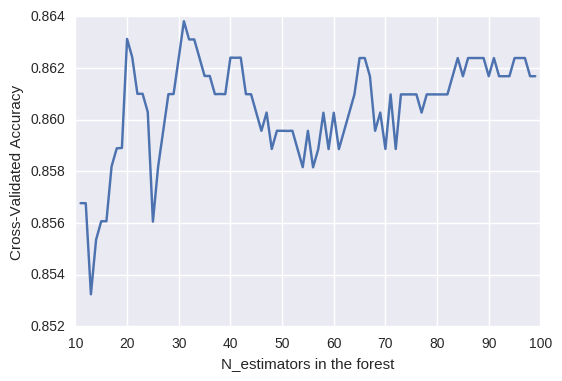

In [39]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)        
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(n_range[10:], scores[10:])
plt.xlabel('N_estimators in the forest')
plt.ylabel('Cross-Validated Accuracy')

#### 1.4.2 max_features

In [40]:
max_features = range(1,len(X.columns))
scores = list()

max_scores = -1
best_n = -1

for i in max_features:
    ml = RandomForestClassifier(max_features=i, random_state=1)
    cross = (cross_val_score(ml, X, y, cv=10))
    scores.append(cross.mean())
    
    if cross.mean() > max_scores:
        max_scores = cross.mean()
        best_n = i
        
# Best values
print(best_n, max_scores)

15 0.866626710618


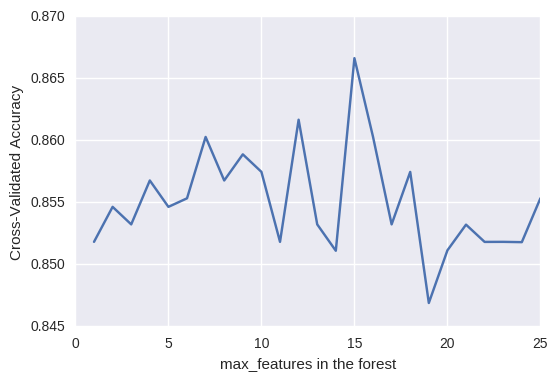

In [41]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)        
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(max_features, scores)
plt.xlabel('max_features in the forest')
plt.ylabel('Cross-Validated Accuracy')

We see that the best option here is 5, which is roughly the square root of the numbers of features.

#### 1.4.3 Model with ALL features

In [42]:
def RFCmodel_cv_featureImportance(X,y):
    """
        Compute the RandomForestClassifier for features dataframe X and classes features y.
        It prints the accuracy of the model using cross-validation and a graph displaying
        the importance for each features.
    """
    
    ml = RandomForestClassifier(n_estimators=51, max_features=5, random_state=1)

    # Cross-validation accuracy
    cross = (cross_val_score(ml, X, y, cv=10))
    print("Cross-validation:", cross.mean())

    # Feature importance
    ml.fit(X,y)
    feature_importance = ml.feature_importances_

    # Combining the features_importance array with the corresponding feature name
    l1 = list(zip(feature_importance, X.columns))
    l1.sort(key=lambda x: x[0], reverse=True)
    features = list(map(lambda x: x[0], l1))
    features_names = list(map(lambda x: x[1], l1))

    # Plot the features_importances graph
    graph = sns.barplot(features_names, features, palette='BuGn_r')
    graph.set_title("Features importance")
    graph.set_xticklabels(labels=features_names, rotation=90)
    plt.show()
    
    
    # Print confusion_matrix
    y_predicted = cross_val_predict(ml, X, y, cv=10)
    cm = metrics.confusion_matrix(y, y_predicted)
    print(cm)
    print("Confusion matrix")
    print("White as white: ", cm[0][0])
    print("White as black: ", cm[0][1])
    print("black as white: ", cm[1][0])
    print("black as black: ", cm[1][1])

Cross-validation: 0.859564479073


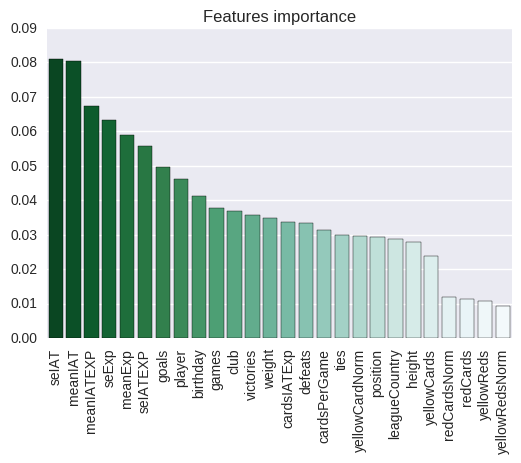

[[1158   32]
 [ 167   60]]
Confusion matrix
White as white:  1158
White as black:  32
black as white:  167
black as black:  60


In [43]:
RFCmodel_cv_featureImportance(X,y)

**BLA BLA BLA **

#### 1.4.4 Model with some selected features

Now we decided to run the model but with some arbitrarily-selected features.

In [44]:
list(data_player.columns)

['defeats',
 'leagueCountry',
 'player',
 'meanIAT',
 'seExp',
 'yellowReds',
 'skinColor',
 'position',
 'yellowCards',
 'height',
 'meanExp',
 'birthday',
 'weight',
 'games',
 'seIAT',
 'club',
 'goals',
 'ties',
 'victories',
 'redCards',
 'meanIATEXP',
 'seIATEXP',
 'cardsPerGame',
 'yellowCardNorm',
 'yellowRedsNorm',
 'redCardsNorm',
 'cardsIATExp',
 'isBlack']

In [45]:
features_to_keep = [
    "leagueCountry",
    "club",
    "weight",
    "height",
    "games",
    "position",
    "birthday",
    'meanIATEXP',
    'seIATEXP',
    'cardsPerGame',
    'yellowCardNorm',
    'yellowRedsNorm',
    'redCardsNorm',
    'cardsIATExp',
]

X = data_player[features_to_keep]

Cross-validation: 0.856742583159


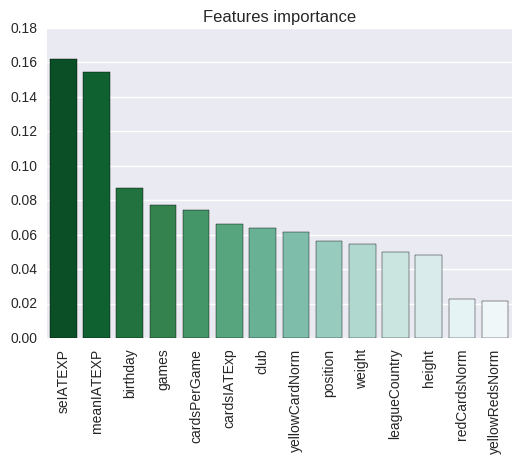

[[1159   31]
 [ 172   55]]
Confusion matrix
White as white:  1159
White as black:  31
black as white:  172
black as black:  55


In [46]:
RFCmodel_cv_featureImportance(X,y)

# 2.

>Aggregate the referee information grouping by soccer player, and use an unsupervised learning technique to cluster the soccer players in 2 disjoint clusters. Remove features iteratively, and at each step perform again the clustering and compute the silhouette score -- can you find a configuration of features with high silhouette score where players with dark and light skin colors belong to different clusters? Discuss the obtained results.

### 2.1 Remove useless referees

Now we need to look a little more into the referees features. As mentionned in the complementary reading for this assignement, there is some referees in this dataset who have less than 22 dyads. Since we want to take into consideration only games in the four leagues (England, France, Germany, and Spain), we need to remove all dyads where a referee has less that 22 games. Note that these doesn't mean we remove all possible noise of our data.

In [47]:
# Group the data by refs
data_by_refs = data.groupby('refNum').size()
refsToKeep = data_by_refs >= 22

# Retrieve the 'refNum' of refs to keep in the data
refsToKeepID = list()
for i,x in enumerate(refsToKeep):
    if x:
        refsToKeepID.append(refsToKeep.index[i])

# Keep only the refs with at least 22 games
data_refs = data[data.refNum.isin(refsToKeepID)]
data_refs.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skinColorDiff,skinColor
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.25,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.25,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.00,1.000
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.00,0.250
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.00,0.000


### 2.2 Group by player

Now that we clean a little bit the refs information, we can group the data by soccer player. We need to perform the aggregation in the same way as for the first part of this assignement. But here, we decided to remove directly some useless features.

In [48]:
list(data_refs.columns)

['playerShort',
 'player',
 'club',
 'leagueCountry',
 'birthday',
 'height',
 'weight',
 'position',
 'games',
 'victories',
 'ties',
 'defeats',
 'goals',
 'yellowCards',
 'yellowReds',
 'redCards',
 'photoID',
 'rater1',
 'rater2',
 'refNum',
 'refCountry',
 'Alpha_3',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp',
 'skinColorDiff',
 'skinColor']

- **player**: The *playerShort* feature is enough, no need to keep players names
- **photoID**: irrelevant
- **rater1**: Skin information stored in *skinColor* column
- **rater2**: Skin information stored in *skinColor* column
- **refNum**: Multiple refs merge together, makes no sens to aggregate here.
- **refCountry**, **Alpha_3**, **meanIAT**,**nIAT**, **seIAT**, **meanExp**,**nExp**, **seExp**: Sames as *refNum*.
- **skinColorDiff**: Not useful anymore

In [49]:
features_drop = ['player', 'photoID', 'rater1', 'rater2', 
                 'refNum', 'refCountry', 'Alpha_3', 'meanIAT',
                 'nIAT', 'seIAT', 'meanExp','nExp','seExp',
                 'skinColorDiff']

data_of_interest = data_refs.drop(features_drop, axis=1)
data_of_interest.head()

,playerShort,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,skinColor
5,aaron-hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0,0,0,0.125
6,aleksandar-kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,0.125
7,alexander-tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0,0,0,1.000
8,anders-lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,1,0,0,0,0,0,0.250
9,andreas-beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,0,0,0,0,0,0,0.000


In [50]:
data_by_player = data_of_interest.groupby('playerShort')
data_player = data_by_player.agg({
        # Keep only one entry per player
        'club'      : 'first',
        'leagueCountry' : 'first',
        'birthday'  : 'first',
        'position'  : 'first',
        'height'    : 'mean',
        'weight'    : 'mean',
        'skinColor' : 'mean',
        
        # Sum referees data
        'games'     : 'sum',
        'victories' : 'sum',
        'ties'      : 'sum',
        'defeats'   : 'sum',
        'goals'     : 'sum',
        'yellowCards' : 'sum',
        'yellowReds': 'sum',
        'redCards'  : 'sum',
    })

data_player.head()

,leagueCountry,defeats,yellowReds,skinColor,position,yellowCards,height,birthday,weight,games,club,goals,ties,victories,redCards
playerShort,,,,,,,,,,,,,,,
aaron-hughes,England,221,0,0.125,Center Back,19,182.0,08.11.1979,71.0,635,Fulham FC,8,174,240,0
aaron-hunt,Germany,119,0,0.125,Attacking Midfielder,39,183.0,04.09.1986,73.0,328,Werder Bremen,59,70,139,1
aaron-lennon,England,115,0,0.250,Right Midfielder,11,165.0,16.04.1987,63.0,411,Tottenham Hotspur,31,96,200,0
aaron-ramsey,England,67,0,0.000,Center Midfielder,31,178.0,26.12.1990,76.0,253,Arsenal FC,39,42,144,1
abdelhamid-el-kaoutari,France,43,4,0.250,Center Back,8,180.0,17.03.1990,73.0,124,Montpellier HSC,1,40,41,2


### 2.3 Prepare data for ML

#### 2.3.1 Numerical values only

Our datasets has, at the moment, different types per column

In [51]:
data_player.dtypes

leagueCountry     object
defeats            int64
yellowReds         int64
skinColor        float64
position          object
yellowCards        int64
height           float64
birthday          object
weight           float64
games              int64
club              object
goals              int64
ties               int64
victories          int64
redCards           int64
dtype: object

In order to be able to use the classifier later on, we need to deal only with numerical values. Therefore, we convert *object* columns into numerical one.


In [52]:
# Convert all columns with type 'object'
col_object = data_player.dtypes == 'object'
for col in data_player.loc[:,col_object]:
    columnEncoder(data_player, col)

Now we only deal with numerical values. Go one step further and only deal with *float64*

In [53]:
data_player = data_player.astype(float)
data_player.dtypes.unique()

array([dtype('float64')], dtype=object)

In [54]:
data_player.head()

,leagueCountry,defeats,yellowReds,skinColor,position,yellowCards,height,birthday,weight,games,club,goals,ties,victories,redCards
playerShort,,,,,,,,,,,,,,,
aaron-hughes,0.0,221.0,0.0,0.125,1.0,19.0,182.0,322.0,71.0,635.0,33.0,8.0,174.0,240.0,0.0
aaron-hunt,2.0,119.0,0.0,0.125,0.0,39.0,183.0,160.0,73.0,328.0,85.0,59.0,70.0,139.0,1.0
aaron-lennon,0.0,115.0,0.0,0.250,10.0,11.0,165.0,641.0,63.0,411.0,78.0,31.0,96.0,200.0,0.0
aaron-ramsey,0.0,67.0,0.0,0.000,3.0,31.0,178.0,1076.0,76.0,253.0,6.0,39.0,42.0,144.0,1.0
abdelhamid-el-kaoutari,1.0,43.0,4.0,0.250,1.0,8.0,180.0,677.0,73.0,124.0,48.0,1.0,40.0,41.0,2.0


#### 2.3.3 Binary SkinColor

In order be able to make comparison between the classifier and the skinColor of a player, we need to have the skin information stored as a binary value.

We add a new column to our dataset: *blackSkin*. It will take value 0 if the skin is defined as *non-black* and value 1 otherwise.

In [55]:
data_player['blackSkin'] = -1
data_player['blackSkin'][data_player.skinColor>0.5] = 1
data_player['blackSkin'][data_player.skinColor<=0.5] = 0

/home/danny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/danny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


### 2.4 Unsupervised learning

We have (arbitrarly) decided to work with the *k_means* algorithm from scikit.

Need to remove the two features about the skin color. As stated above, we will use the *blackSkin* feature to compute the percentage of dark and light skin colors in the clusters.

In [56]:
X = data_player.drop(['skinColor', 'blackSkin'], axis=1)
y = data_player.blackSkin

**Demonstration of the method used**

In will, compute which of the features is the best candidate to being removed. If the silhouette score by removing this feature is better than by keeping it, we drop the specific column and go through the loop one more time.

Below, we display a graph that shows the first iteration of the algorithm.

In [57]:
caca = X


scale = StandardScaler().fit(caca)
caca = scale.transform(caca)
caca = pd.DataFrame(caca, columns=X.columns)
caca

,leagueCountry,defeats,yellowReds,position,yellowCards,height,birthday,weight,games,club,goals,ties,victories,redCards
0,-1.492118,3.718841,-0.690851,-1.030168,-0.499568,-0.024512,-0.838902,-0.742844,2.875825,-0.411246,-0.465300,3.567581,1.748596,-0.746581
1,0.298424,1.152783,-0.690851,-1.341461,0.310264,0.122558,-1.286372,-0.461144,0.674529,1.586962,0.764420,0.429076,0.440688,0.014512
2,-1.492118,1.052153,-0.690851,1.771467,-0.823501,-2.524687,0.042228,-1.869643,1.269668,1.317972,0.089280,1.213702,1.230613,-0.746581
3,-1.492118,-0.155404,-0.690851,-0.407583,-0.013669,-0.612788,1.243769,-0.038594,0.136753,-1.448776,0.282177,-0.415906,0.505436,0.014512
4,-0.596847,-0.759182,2.211953,-1.030168,-0.944976,-0.318650,0.141666,-0.461144,-0.788221,0.165160,-0.634085,-0.476261,-0.828371,0.775606
5,-0.596847,-1.035914,0.034850,1.771467,-0.823501,-0.318650,0.122331,-0.320294,-1.003332,-0.334391,-0.585861,-0.989286,-0.854270,-0.746581
6,-0.596847,-1.664850,-0.690851,0.215003,-1.268909,1.004972,1.611137,0.524805,-1.533937,1.202691,-0.658197,-1.472133,-1.281606,-0.746581
7,-0.596847,-1.790637,-0.690851,0.215003,-1.268909,0.857903,0.423407,0.947355,-1.655833,-0.334391,-0.658197,-1.653201,-1.359304,-0.746581
8,-0.596847,-0.281191,-0.690851,-0.096290,-0.418585,-0.318650,0.486937,-1.165394,-0.816903,1.125837,-0.585861,-0.928930,-0.931968,0.775606
9,0.298424,-1.212016,-0.690851,0.526296,-1.147434,-0.465719,-1.523918,-0.883694,-1.318827,1.087410,-0.658197,-1.441955,-1.139161,0.014512


In [58]:
silhouettes = list()

for col in caca.columns:
    data_without_col = caca.drop(col, axis=1)
    
    kmeans = KMeans(n_clusters=2).fit(data_without_col)
    silhouette = sklearn.metrics.silhouette_score(data_without_col, kmeans.labels_)
    
    silhouettes.append(silhouette)
    
    #skin_sep = (kmeans.labels_ == y).sum() / len(y)
    #skin_separations.append(max(skin_sep, 1-skin_sep))

In [59]:
# Add columns names to columns silhouette value and order
l1 = list(zip(silhouettes, X.columns))
l1.sort(key=lambda x: x[0], reverse=True)

sil_values = list(map(lambda x: x[0], l1))
sil_names = list(map(lambda x: x[1], l1))

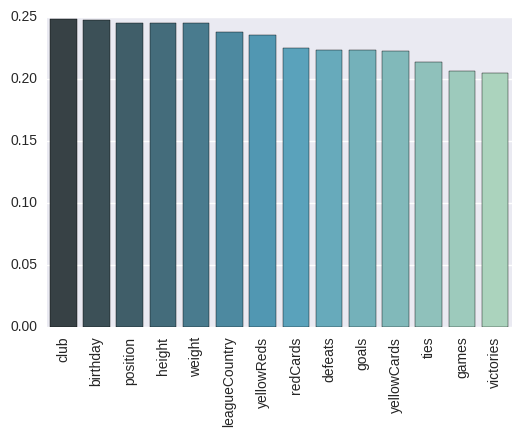

In [60]:
# Plot graph
graph = sns.barplot(sil_names, sil_values, palette='GnBu_d')
graph.set_xticklabels(labels=sil_names, rotation=90)
plt.show()

So here,the leagueCountry feature needs to be remove

NOW, LOOP !

In [61]:
new_data = caca
kmeans = KMeans(n_clusters=2).fit(caca)
data_silhouette = sklearn.metrics.silhouette_score(caca, kmeans.labels_)
        
print("TOUT", data_silhouette)

to_del = "nope"
to_del_min = -1

while True:
    for col in new_data.columns:
        data_without_col = new_data.drop(col, axis=1)

        kmeans = KMeans(n_clusters=2).fit(data_without_col)
        silhouette = sklearn.metrics.silhouette_score\
                        (data_without_col, kmeans.labels_)

        if silhouette > to_del_min:
            to_del = col
            to_del_min = silhouette

        #skin_sep = (kmeans.labels_ == y).sum() / len(y)
        #skin_separations.append(max(skin_sep, 1-skin_sep))
    if to_del_min > data_silhouette:
        new_data = new_data.drop(to_del, axis=1)
        data_silhouette = to_del_min
        print(to_del, "DELETED")

    else:
        break

TOUT 0.229668688601
club DELETED
birthday DELETED
weight DELETED
height DELETED
position DELETED
leagueCountry DELETED
yellowReds DELETED
redCards DELETED
yellowCards DELETED
goals DELETED
defeats DELETED
ties DELETED
games DELETED


ValueError: Found array with 0 feature(s) (shape=(1416, 0)) while a minimum of 1 is required.